# Data Cleaning on Online Sales Data

The [dataset](https://www.kaggle.com/datasets/arnavsmayan/online-retail-sales-dataset) will provide synthetic data for online retail sales, which include details of customer transactions and orders with regard to the involved items, their quantities, prices, discounts, methods of payment, and the customers' demographics for analysis in terms of buying behavior, sales trend, inventory management, and marketing strategy.

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
import statsmodels.api as sm
from scipy.stats import shapiro, normaltest, levene, zscore

In [2]:
# Set visual display settings
sns.set(style='whitegrid')

## Load CSV

In [3]:
init_df = dd.read_csv('online_retail_sales_dataset.csv')

In [4]:
# Computed data
computed_df = init_df.compute()

# initialize variables
# specify numeric columns
numeric_columns = init_df.select_dtypes(include=['int64', 'float64']).columns

# specify columns to eliminate
columns_to_exclude = ['transaction_id', 'customer_id', 'product_id']

# columns for usual numeric process
cols_to_process = ['quantity', 'price', 'discount', 'customer_age', 'total_amount']

# filter out the specified numeric columns
filtered_numeric_columns = [col for col in numeric_columns if col not in columns_to_exclude]

# DF of numeric columns to process
filtered_numeric_df = computed_df[filtered_numeric_columns]

selected_numeric_cols = init_df[filtered_numeric_columns]

In [5]:
# View first 5 rows
init_df.head()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount
0,1,2023-01-01 00:00:00,1993,915,Home & Kitchen,8,103.30,0.23,Gift Card,27,Female,North America,636.33
1,2,2023-01-01 00:01:00,3474,553,Clothing,9,180.28,0.31,Gift Card,53,Other,South America,1119.54
2,3,2023-01-01 00:02:00,4564,248,Beauty & Personal Care,7,81.58,0.27,Debit Card,34,Other,North America,416.87
3,4,2023-01-01 00:03:00,1133,948,Clothing,3,235.20,0.00,Debit Card,50,Other,Australia,705.60
4,5,2023-01-01 00:04:00,3626,284,Books,9,453.00,0.34,Credit Card,23,Female,Australia,2690.82


## DF Overview

In [6]:
# Check datatypes of the column 
init_df.dtypes
# there are 8 numeric & 5 non-numeric cols

transaction_id                 int64
timestamp            string[pyarrow]
customer_id                    int64
product_id                     int64
product_category     string[pyarrow]
quantity                       int64
price                        float64
discount                     float64
payment_method       string[pyarrow]
customer_age                   int64
customer_gender      string[pyarrow]
customer_location    string[pyarrow]
total_amount                 float64
dtype: object

In [7]:
# get the number of rows
dataset_rows = init_df.shape[0].compute()
# get the number of columns
dataset_cols = init_df.columns.size
print(f"Number of rows: {dataset_rows}, Number of columns: {dataset_cols}")

Number of rows: 1000000, Number of columns: 13


In [8]:
# get the total number of elements
init_df.size.compute()

13000000

In [9]:
# get the number of partitions
init_df.npartitions

1

In [10]:
# Descriptive stat of selected numeric columns
init_df[['quantity', 'price', 'discount', 
         'customer_age', 'total_amount']].describe().compute()

,quantity,price,discount,customer_age,total_amount
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,5.003086,252.445705,0.250204,43.508625,946.839858
std,2.581004,142.868633,0.144384,15.007346,810.902205
min,1.000000,5.000000,0.000000,18.000000,2.560000
25%,3.000000,128.690000,0.130000,31.000000,297.180000
50%,5.000000,252.700000,0.250000,44.000000,715.710000
75%,7.000000,375.990000,0.380000,57.000000,1397.750000
max,9.000000,500.000000,0.500000,69.000000,4496.130000


## Data Cleaning

### Standardizing Format: Explicit Data Type Conversion

[Explicitly defining data types for your columns ensures consistency, prevents implicit conversions, enhances performance, and avoids errors during analysis](https://www.geeksforgeeks.org/explicitly-define-datatype-in-a-python-function/.). This practice is crucial for large datasets or collaborative work. However, if you're confident in your data's structure or only conducting exploratory analysis, explicit type definitions may not be necessary.

In [11]:
init_df['customer_id'] = init_df['customer_id'].astype('int64')  # Ensure customer_id is integer type
init_df['transaction_id'] = init_df['transaction_id'].astype('int64') 
init_df['product_id'] = init_df['product_id'].astype('int64') 

init_df['quantity'] = init_df['quantity'].astype('int64')
init_df['price'] = init_df['price'].astype('float64') 
init_df['discount'] = init_df['discount'].astype('float64')  
init_df['customer_age'] = init_df['customer_age'].astype('int64')
init_df['total_amount'] = init_df['total_amount'].astype('float64')

init_df['timestamp'] = init_df['timestamp'].astype('string[pyarrow]')  
init_df['product_category'] = init_df['product_category'].astype('string[pyarrow]')  
init_df['payment_method'] = init_df['payment_method'].astype('string[pyarrow]')  
init_df['customer_gender'] = init_df['customer_gender'].astype('string[pyarrow]')  
init_df['customer_location'] = init_df['customer_location'].astype('string[pyarrow]')  


In [12]:
# check again the data types
init_df.dtypes

transaction_id                 int64
timestamp            string[pyarrow]
customer_id                    int64
product_id                     int64
product_category     string[pyarrow]
quantity                       int64
price                        float64
discount                     float64
payment_method       string[pyarrow]
customer_age                   int64
customer_gender      string[pyarrow]
customer_location    string[pyarrow]
total_amount                 float64
dtype: object

### Standardizing Format: Formatting Timestamp

[In the Philippines, the recommended timestamp format conforms to the ISO 8601 standard](https://en.wikipedia.org/wiki/Date_and_time_notation_in_the_Philippines#:~:text=Date%20and%20time%20notation%20in%20the%20Philippines%20varies%20across%20the%20country%20in%20various%2C%20customary%20formats.%20Some%20government%20agencies%20in%20the%20Philippines%20have%20adopted,Multi%2DPurpose%20ID.), which prescribes the format as `YYYY-MM-DD` for dates and utilizes the 24-hour clock format for times, resulting in a complete representation such as 2023-01-01T00:02:00. This standardization enhances clarity and mitigates ambiguity in datetime notation, making it appropriate for legal and technical applications.

Our group formatted the timestamp column to ISO 8601 utilizing the 24-hour clock format for times and created another `df['date']` for timestamp without 24-hour clock format `(YYYY-MM-DD)`.

In [13]:
# ISO 8601 utilizes the 24-hour clock format for times
init_df['timestamp'] = dd.to_datetime(init_df['timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')
computed_df['timestamp'] = dd.to_datetime(computed_df['timestamp']).dt.strftime('%Y-%m-%dT%H:%M:%S')

# ISO 8601 with date only
init_df['date'] = dd.to_datetime(init_df['timestamp']).dt.date
computed_df['date'] = dd.to_datetime(computed_df['timestamp']).dt.date

In [14]:
# check the formatting the created columns
init_df.tail()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount,date
999995,999996,2024-11-25T10:35:00,1324,833,Clothing,9,318.66,0.30,PayPal,58,Other,Asia,2007.56,2024-11-25
999996,999997,2024-11-25T10:36:00,3671,260,Books,7,283.78,0.30,Credit Card,32,Male,North America,1390.52,2024-11-25
999997,999998,2024-11-25T10:37:00,3651,293,Electronics,8,418.59,0.42,Gift Card,19,Male,Australia,1942.26,2024-11-25
999998,999999,2024-11-25T10:38:00,3253,534,Home & Kitchen,6,258.94,0.13,Credit Card,38,Other,North America,1351.67,2024-11-25
999999,1000000,2024-11-25T10:39:00,3337,826,Electronics,9,76.06,0.47,Gift Card,59,Male,North America,362.81,2024-11-25


In [15]:
# check nuo. of columns
dataset_cols = init_df.columns.size
print(f'Updated number of columns: {dataset_cols}')

Updated number of columns: 14


### Handling Missisng Values

In [16]:
# identify columns with missing values
computed_df.isnull().sum()
# DF has no NAN

transaction_id       0
timestamp            0
customer_id          0
product_id           0
product_category     0
quantity             0
price                0
discount             0
payment_method       0
customer_age         0
customer_gender      0
customer_location    0
total_amount         0
date                 0
dtype: int64

**Suggestions if missing values are present**

For numeric column:

`df['col'] = df['col'].fillna(0)`

Option to fill missing values in a specific column with the mean:

`df['price'].fillna(df['price'].mean(), inplace=True)`
For non-numeric columns replace with appropriate string:

`df['col'] = df['col'].fillna('blah!')`

Option to fill missing values in a specific column with the mean:

`df['price'].fillna(df['price'].mean(), inplace=True)`

**Rationale**: Handling missing values ensures comprehensive datasets, reducing biases during analysis. This practice allows for better data integrity and improved predictive performance.</p>

### Handling Duplicate Rows

<b>Suggestion if there are duplicate rows</b>

Remove duplicate rows
```python
original_df = original_df.drop_duplicates()
```

**Rationale**: By eliminating duplicates, data clarity is enhanced, allowing for more accurate insights from analyses.


In [17]:
# check for duplicate rows
computed_df.duplicated().sum()
# DF has no duplicate rows

np.int64(0)

### Visualizing the Data Distribution

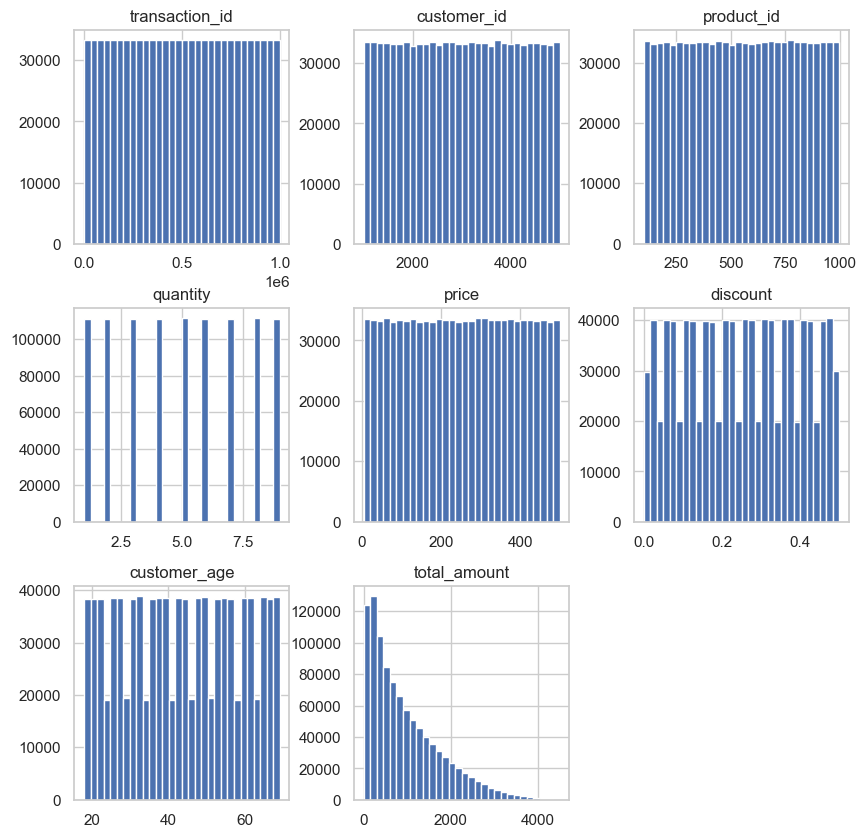

In [18]:
# Histogram for all numerical features
computed_df.hist(figsize=(10, 10), bins=30)
plt.title('Distribution of Numerical Features')
plt.show()

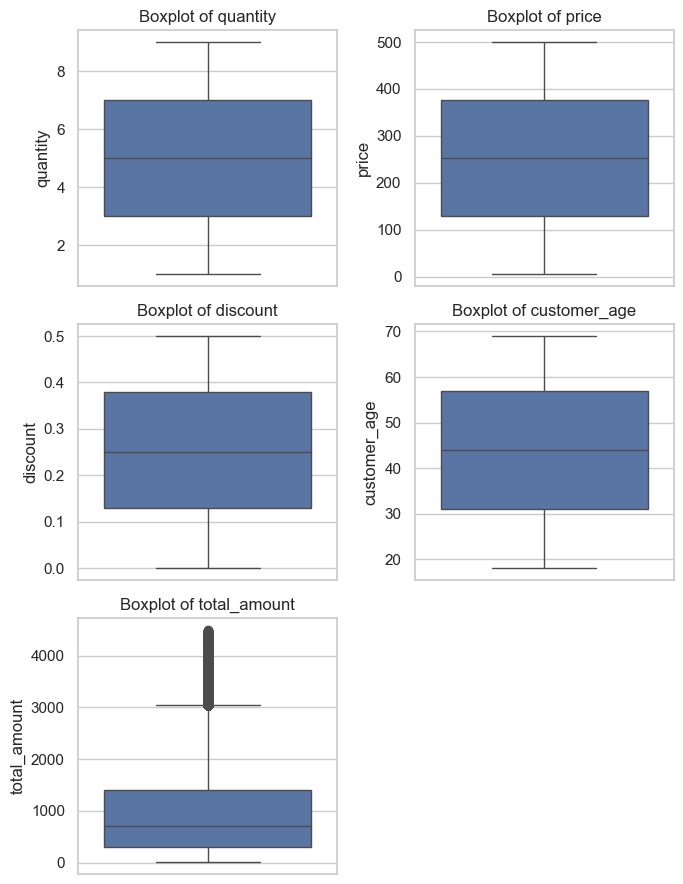

In [19]:
# Boxplot for a specific numerical column
# Set overall figure size for the plots
ncols = 2  # Number of columns
nrows = (len(cols_to_process) + ncols - 1) // ncols  # Calculate rows needed

plt.figure(figsize=(7, nrows * 3))  # Adjust height based on the number of rows

# Create boxplots for each selected column
for i, column in enumerate(cols_to_process):
    plt.subplot(nrows, ncols, i + 1)  # Adjusts the number of rows and columns for subplots
    sns.boxplot(data=computed_df, y=column)
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()

[In a boxplot, the presence of a black mark at the maximum quantile typically represents the maximum value of the dataset](https://www.statology.org/how-to-read-box-plot-with-outliers/), excluding outliers.​ This mark indicates the highest observation that falls within a defined range, providing insight into the data distribution and helping to visualize its spread. No usually how outliers looks like, but it can be, as it is outside the whiskers of both ends.

### Outlier Detection & Deletion

**Definition of Quartiles**:

- Q1 (First Quartile): This is the 25th percentile of the data, meaning that 25% of the data points are below this value.
- Q3 (Third Quartile): This is the 75th percentile, indicating that 75% of the data points are below this value.

**Calculating IQR**:

- The Interquartile Range (IQR) is calculated as:
```bash
IQR = Q3 - Q1
```

- The IQR represents the range within which the central 50% of the data points lie.

**Identifying Outliers**:

- Outliers are defined as any data points that fall below `Q1 − 1.5 * IQR` or above `Q3 + 1.5 * IQR`.
- Once outliers are identified, they can be removed from the dataset to ensure that subsequent analyses are not skewed by these extreme values.

In [21]:
def count_outliers_iqr(dataframe, columns):
    outlier_counts = {}
    for column in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count the outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]  # Number of outliers
    
    return outlier_counts

# Count outliers in the specified numeric columns
outlier_counts = count_outliers_iqr(computed_df, cols_to_process)

In [22]:
print(outlier_counts)

{'quantity': 0, 'price': 0, 'discount': 0, 'customer_age': 0, 'total_amount': 21985}


In [49]:
def remove_outliers_iqr(df, numeric_columns):
    df_filtered = df.copy()

    # For each numeric column, Q1 and Q3 are calculated using quantile(), and then IQR is computed.
    
    for column in numeric_columns:
        Q1 = df_filtered[column].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df_filtered[column].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        
        # Define bounds for outliers
        # The lower and upper bounds for identifying outliers are established.
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        # Rows containing outliers are removed based on these bounds
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]

    # Cleaned DataFrame without outliers is returned
    return df_filtered

computed_df = remove_outliers_iqr(computed_df, cols_to_process)

# Caveat: must run this function several times to remove the outlier completely

outlier_counts = count_outliers_iqr(computed_df, cols_to_process)

In [50]:
print(outlier_counts)

{'quantity': 0, 'price': 0, 'discount': 0, 'customer_age': 0, 'total_amount': 0}


In [51]:
# Updating the DF of numeric columns to process
filtered_numeric_df = computed_df[filtered_numeric_columns]

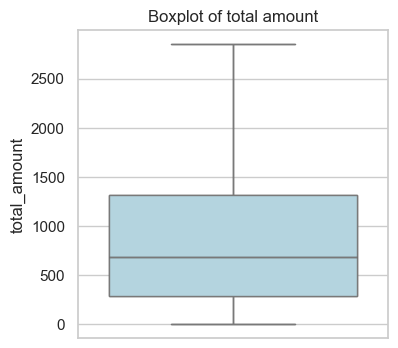

In [52]:
# Boxplot to confirm the removal of outlier
plt.figure(figsize=(4,4))
sns.boxplot(y='total_amount', data=filtered_numeric_df)  # Replace 'sepal_length' with your variable of interest
sns.boxplot(y='total_amount', data=filtered_numeric_df, color='lightblue')
plt.title('Boxplot of total amount')
plt.show()

In [53]:
# confirm the number of rows
computed_df.shape

(968218, 14)

**Rationale**: Outlier management assures the robustness of analyses, as they can detrimentally affect interpretations and model accuracy. Ensure that the dataset has enough data points after removing outliers; if too many rows are removed, consider adjusting the IQR multiplier or using alternative methods like Z-score or robust statistical techniques.